In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn.metrics as metrics

In [2]:
test_features = np.load('../../Arrays/test_features.npy')
test_labels = np.load('../../Arrays/test_labels.npy')

In [3]:
model = keras.models.load_model("../../Models/granulomas_final_tf_nn_v1.h5") 

c:\Users\bence\Projects\BIO446\McKinnon-Rosati-Laboratory\env\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [4]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 23693)          │        94,772 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8192)           │   194,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8192)           │        32,768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 30)             │        30,750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 238,335,572 (909.18 MB)

 Trainable params: 238,257,464 (908.88 MB)

 Non-trainable params: 78,106 (305.10 KB)

 Optimizer params: 2 (12.00 B)

In [5]:
prediction = model.predict(test_features)

173/173 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step


In [6]:
max_indices = np.argmax(prediction, axis=1)

In [7]:
def overall_metrics(y_true, y_pred, average='weighted'):

    results = {
        'accuracy': metrics.accuracy_score(y_true, y_pred),
        'precision': metrics.precision_score(y_true, y_pred, average=average),
        'recall': metrics.recall_score(y_true, y_pred, average=average),
        'f1_score': metrics.f1_score(y_true, y_pred, average=average),
    }

    return results

In [8]:
def class_metrics(y_true, y_pred):
    return metrics.classification_report(y_true, y_pred)

In [9]:
def create_confusion_matrix(y_true, y_pred):
    return metrics.confusion_matrix(y_true, y_pred)

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    confusion_matrix = create_confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sb.heatmap(confusion_matrix, annot=False, cmap='Reds', cbar=True, xticklabels=np.unique(np.arange(30)), yticklabels=np.unique(np.arange(30)))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [11]:
def roc_auc_ovr(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, multi_class='ovr')

In [12]:
def roc_auc_ovo(y_true, y_score):
    return metrics.roc_auc_score(y_true, y_score, multi_class='ovo')

In [13]:
def average_precision(y_true, y_score): 
    return metrics.average_precision_score(y_true, y_score, average='weighted')

In [14]:
def balanced_accuracy(y_true, y_pred):
    return metrics.balanced_accuracy_score(y_true, y_pred)

In [15]:
overall_metrics(test_labels, max_indices)

{'accuracy': 0.9255569643180583,
 'precision': 0.9261210688303138,
 'recall': 0.9255569643180583,
 'f1_score': 0.924272167022818}

In [16]:
print(class_metrics(test_labels, max_indices))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       359
           1       0.97      1.00      0.98       421
           2       0.91      0.96      0.93      1129
           3       0.96      0.98      0.97       140
           4       0.95      0.94      0.94       708
           5       0.76      0.76      0.76       214
           6       0.99      0.97      0.98       139
           7       0.86      0.86      0.86       187
           8       0.87      0.84      0.86        32
           9       0.85      0.79      0.82        66
          10       0.96      0.82      0.88        83
          11       1.00      0.99      0.99       210
          12       0.91      0.84      0.87        98
          13       0.92      0.94      0.93       141
          14       0.97      0.97      0.97       357
          15       0.89      0.97      0.93       175
          16       1.00      1.00      1.00        27
          17       0.98    

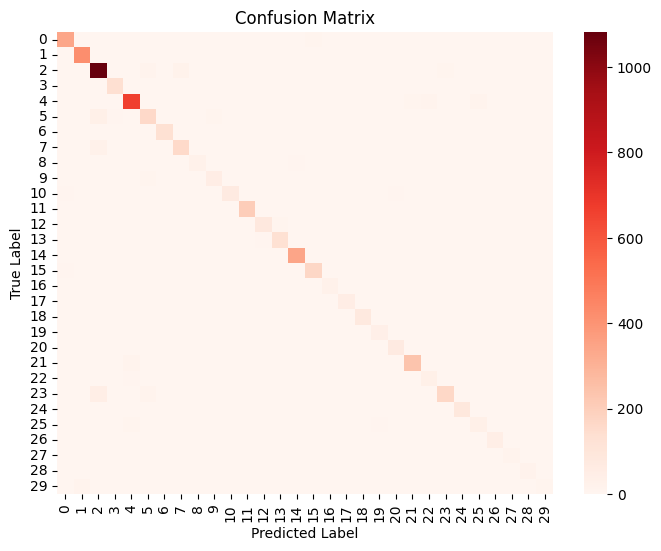

In [17]:
plot_confusion_matrix(test_labels, max_indices)

In [18]:
roc_auc_ovr(test_labels, prediction)

0.9951714083645519

In [19]:
roc_auc_ovo(test_labels, prediction)

0.9950603602563541

In [20]:
average_precision(test_labels, prediction)

0.9642743567974271

In [21]:
balanced_accuracy(test_labels, max_indices)

0.8964732936499209